In [356]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [357]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

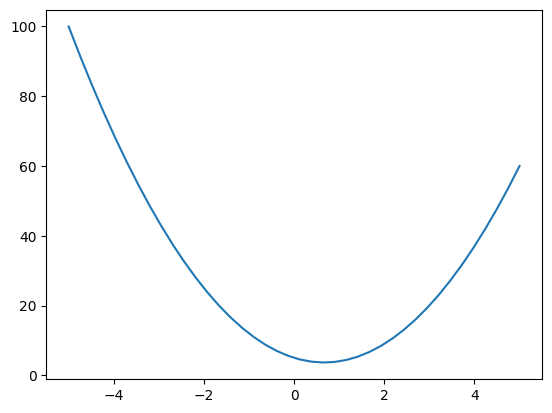

In [358]:
xs = np.linspace(-5, 5, 40).astype(float)
ys = f(xs)

plt.plot(xs, ys)

In [359]:
h = 1e-3
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

## NOTE:

very important to make sure the gradients are accumulated `+=` in the `_backward` function, because if we're using the same variable, say `v = a + a` then the gradient w.r.t a should be `2`, but we get `1` because the gradients are overwriten

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = self
        if not isinstance(other, Value):
            self.data += other
        else:
            out = Value(self.data + other.data, (self, other), '+')
            
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo: list[Value] = []
        visited = set()
        
        def build_topological_sort(v: Value):
            if v not in visited:
                visited.add(v)
                
                for child in v._prev:
                    build_topological_sort(child)
    
                topo.append(v)
                
        build_topological_sort(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
            
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - (t ** 2)) * out.grad
        
        out._backward = _backward
        return out
    
    def setLabel(self, label):
        self.label = label
        return self
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = (a * b).setLabel('e')
d = (e + c).setLabel('d')
f = Value(-2.0, label='f')
L = (d * f).setLabel('L')
L

Value(data=-8.0)

In [361]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    
    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={ 'rankdir': 'LR' })
    nodes, edges = trace(root)
    
    
    for node in nodes:
        uid = str(id(node))
        # print(node)
        dot.node(name=uid, label=f"{node.label}|data {node.data:.4f}|grad {node.grad:.4f}", shape='record')
        if node._op:
            # this value was generated as a result of some operation, create an operation node
            
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
            
    for n1, n2 in edges:
        # print("edge", n1, n2)
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

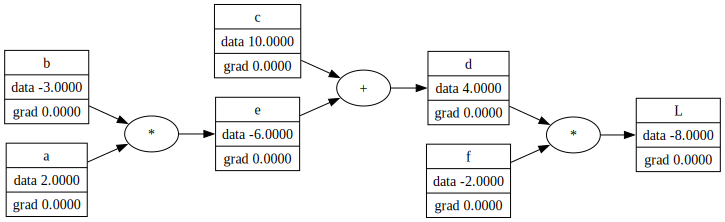

In [362]:
"""
    in the context of neural networks, the leaf nodes would be the "weights" and the nodes that are 
    generated from the operation between other nodes would be the input (w*x + b, where w will be independent)
    now we need to track the gradient of L with respect to each node. 
    however in neural networks we dont really need to find grads w.r.t the inputs itself, so we will skip non-leaf node gradients
"""
draw_dot(L)



In [363]:
"""
    to calculate how L changes by chaning L, simply 
    dL/dL which is obviously 1
"""
L.grad = 1

In [364]:
"""
    now to calculate how L changes by nudging f and d
    we need, dL/df and dL/dd
    
    L = f * d
    
    so 
    dL/df = d
    dL/dd = f
"""

d.grad = f.data
f.grad = d.data

In [365]:

"""
    now comes the tricky part, we need to see how L changes by nudging c and e
    however
    
    L = f * d
    where, 
    d = c + e
    
    we know how changing d affects L (dL/dd)
    if we can calculate how changing c and e affects d then we can calculate
    
    dL/de = dL/dd * dd/de
    dL/dc = dL/dd * dd/dc
    
    here dd/de and dd/dc are also known as local gradients
    
    dd/dc = 1
    dd/de = 1
"""

e.grad = 1 * d.grad
c.grad = 1 * d.grad



In [366]:
"""
    now for dL/db and dL/da
    
    
    L = f * d
    d = c + e
    e = a * b
    
    dL/db = dL/de * de/da
    dL/da = dL/de * de/db

"""

a.grad = e.grad * b.data
b.grad = e.grad * a.data

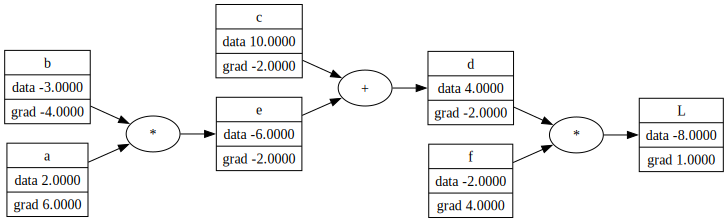

In [367]:
draw_dot(L)

In [368]:
a.data += 1e-3 * a.grad
b.data += 1e-3 * b.grad
c.data += 1e-3 * c.grad
f.data += 1e-3 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.928064095999999


In [369]:
def numerical_eval():
    
    """
        evaluate if your gradient logic is correct by applying the differential
        
        df/dx = limt h -> 0, (f(x + h) - f(x)) / h
    """
    # original value
    h = 1e-3
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b') + h
    c = Value(10.0, label='c')
    e = (a * b).setLabel('e')
    d = (e + c).setLabel('d')
    f = Value(-2.0, label='f')
    L1 = (d * f).setLabel('L')
    L1
    
    # increase by a small h
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = (a * b).setLabel('e')
    d = (e + c).setLabel('d')
    f = Value(-2.0, label='f')
    L2 = (d * f).setLabel('L')
    L2
    
    
    return (L2.data - L1.data)/h
numerical_eval()

3.9999999999995595

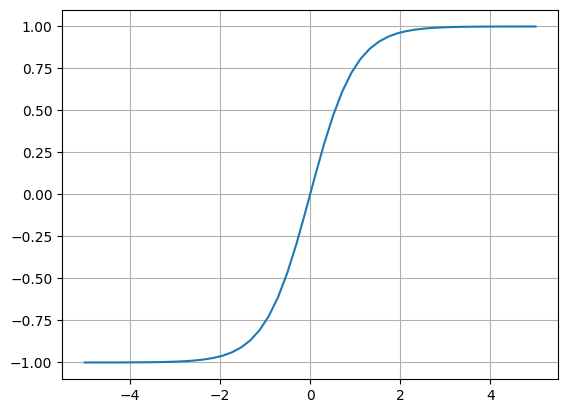

In [370]:
plt.plot(np.linspace(-5, 5, 50), np.tanh(np.linspace(-5, 5, 50))); plt.grid()

In [379]:
# demo neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137, label="b")

x1w1 = (x1 * w1).setLabel('x1 * w1')
x2w2 = (x2 * w2).setLabel('x2 * w2')

x1w1x2w2 = (x1w1 + x2w2).setLabel('x1*w1 + x2*w2')

n = (x1w1x2w2 + b).setLabel("n")

o = n.tanh().setLabel("output")


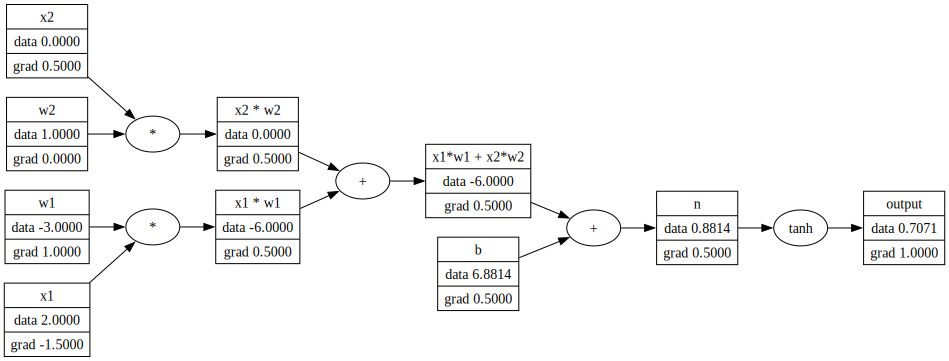

In [382]:
draw_dot(o)


In [381]:
o.backward()

In [373]:
o.grad = 1.0

print(o._prev)
o._backward()

{Value(data=0.8813700000000004)}


In [374]:
# do/dn = 1 - tanh(n) ** 2 = 1 - o ** 2

# n.grad = 1 - (o.data) ** 2

n._backward()


In [375]:
# do/dz = do/dn * dn/dz
# do/db = do/dn * dn/db

# x1w1x2w2.grad = n.grad * 1
# b.grad = n.grad * 1

x1w1x2w2._backward()
b._backward()

In [376]:
# d/dx1w2 = do/dz * dz/dw1w2

# x1w1.grad = x1w1x2w2.grad * 1
# x2w2.grad = x1w1x2w2.grad * 1

x1w1._backward()
x2w2._backward()

In [377]:
# w2.grad = x2.data * x2w2.grad
# x2.grad = w2.data * x2w2.grad


# w1.grad = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad

# w2._backward()


In [378]:
# import torch

# z = torch.tensor(-6.0, requires_grad=True)
# b = torch.tensor(6.8814, requires_grad=True)

# n = z + b
# o = torch.tanh(n)
# print(o)

# o.backward()

# print(z.grad)